In [3]:
import os
import torch
import argparse
from PIL import Image
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.utils import make_image_grid
import gradio as gr
import numpy as np

class TextToImageGenerator:
    def _init_(self, model_id="runwayml/stable-diffusion-v1-5", device=None):
        """Initialize the Text-to-Image Generator with a specified model."""
        self.model_id = model_id
        
        # Determine device (CUDA GPU if available, otherwise CPU)
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Load the pipeline with optimizations
        self.pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16 if self.device == "cuda" else torch.float32,
            safety_checker=None  # For research purposes - remove in production
        )
        
        # Use DPM-Solver++ scheduler for faster inference
        self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(self.pipe.scheduler.config)
        
        # Move to device
        self.pipe = self.pipe.to(self.device)
        
        # Enable attention slicing for lower memory usage
        self.pipe.enable_attention_slicing()
        
        # Enable vae slicing for lower memory usage
        if hasattr(self.pipe, "enable_vae_slicing"):
            self.pipe.enable_vae_slicing()

    def generate_image(
        self, 
        prompt, 
        negative_prompt="", 
        height=512, 
        width=512, 
        num_inference_steps=30, 
        guidance_scale=7.5, 
        num_images=1,
        seed=None
    ):
        """Generate images from a text prompt with various parameters."""
        # Set seed for reproducibility if provided
        if seed is not None:
            generator = torch.Generator(device=self.device).manual_seed(seed)
        else:
            generator = None
            
        # Generate images
        images = self.pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            height=height,
            width=width,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            num_images_per_prompt=num_images,
            generator=generator
        ).images
        
        return images
    
    def save_images(self, images, output_dir="outputs", base_filename="generated"):
        """Save generated images to disk."""
        os.makedirs(output_dir, exist_ok=True)
        
        saved_paths = []
        for i, image in enumerate(images):
            filename = f"{base_filename}_{i}.png"
            path = os.path.join(output_dir, filename)
            image.save(path)
            saved_paths.append(path)
            print(f"Image saved to {path}")
            
        return saved_paths
    
    def create_grid(self, images, rows=2):
        """Create a grid of images."""
        return make_image_grid(images, rows=rows)


def main():
    """Command-line interface for the Text-to-Image Generator."""
    parser = argparse.ArgumentParser(description="Text-to-Image Generator using Stable Diffusion")
    parser.add_argument("--prompt", type=str, required=True, help="Text prompt for image generation")
    parser.add_argument("--negative_prompt", type=str, default="", help="Negative prompt to avoid certain elements")
    parser.add_argument("--height", type=int, default=512, help="Image height")
    parser.add_argument("--width", type=int, default=512, help="Image width")
    parser.add_argument("--steps", type=int, default=30, help="Number of inference steps")
    parser.add_argument("--guidance", type=float, default=7.5, help="Guidance scale")
    parser.add_argument("--num_images", type=int, default=1, help="Number of images to generate")
    parser.add_argument("--seed", type=int, default=None, help="Seed for reproducibility")
    parser.add_argument("--output_dir", type=str, default="outputs", help="Directory to save outputs")
    parser.add_argument("--model", type=str, default="runwayml/stable-diffusion-v1-5", help="Model ID")
    parser.add_argument("--device", type=str, default=None, help="Device to use (cuda/cpu)")
    
    args = parser.parse_args()
    
    # Initialize generator
    generator = TextToImageGenerator(model_id=args.model, device=args.device)
    
    # Generate images
    images = generator.generate_image(
        prompt=args.prompt,
        negative_prompt=args.negative_prompt,
        height=args.height,
        width=args.width,
        num_inference_steps=args.steps,
        guidance_scale=args.guidance,
        num_images=args.num_images,
        seed=args.seed
    )
    
    # Save images
    generator.save_images(images, output_dir=args.output_dir)
    
    # Create grid if multiple images
    if len(images) > 1:
        grid = generator.create_grid(images)
        grid.save(os.path.join(args.output_dir, "grid.png"))
        print(f"Grid saved to {os.path.join(args.output_dir, 'grid.png')}")


def create_ui():
    """Create a Gradio UI for the Text-to-Image Generator."""
    generator = TextToImageGenerator()
    
    def generate_and_display(
        prompt, 
        negative_prompt, 
        height, 
        width, 
        num_inference_steps, 
        guidance_scale,
        num_images,
        seed
    ):
        # Use -1 for random seed
        seed_value = None if seed == -1 else seed
        
        images = generator.generate_image(
            prompt=prompt,
            negative_prompt=negative_prompt,
            height=height,
            width=width,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            num_images=num_images,
            seed=seed_value
        )
        
        generator.save_images(images, output_dir="outputs")
        
        if len(images) == 1:
            return images[0]
        else:
            grid = generator.create_grid(images)
            return grid
    
    with gr.Blocks(title="Text-to-Image Generator") as demo:
        gr.Markdown("# Text-to-Image Generator using Stable Diffusion")
        
        with gr.Row():
            with gr.Column():
                prompt = gr.Textbox(label="Prompt", placeholder="Enter your prompt here...")
                negative_prompt = gr.Textbox(label="Negative Prompt", placeholder="Enter elements to avoid...")
                
                with gr.Row():
                    height = gr.Slider(minimum=256, maximum=768, step=32, value=512, label="Height")
                    width = gr.Slider(minimum=256, maximum=768, step=32, value=512, label="Width")
                
                with gr.Row():
                    steps = gr.Slider(minimum=10, maximum=50, step=1, value=30, label="Inference Steps")
                    guidance = gr.Slider(minimum=1, maximum=15, step=0.5, value=7.5, label="Guidance Scale")
                
                with gr.Row():
                    num_images = gr.Slider(minimum=1, maximum=4, step=1, value=1, label="Number of Images")
                    seed = gr.Number(value=-1, label="Seed (-1 for random)")
                
                generate_btn = gr.Button("Generate")
            
            with gr.Column():
                output_image = gr.Image(label="Generated Image")
        
        generate_btn.click(
            generate_and_display,
            inputs=[prompt, negative_prompt, height, width, steps, guidance, num_images, seed],
            outputs=[output_image]
        )
    
    return demo


if _name_ == "_main_":
    import sys
    
    if len(sys.argv) > 1:
        # Command-line interface
        main()
    else:
        # Gradio UI
        demo = create_ui()
        demo.launch()

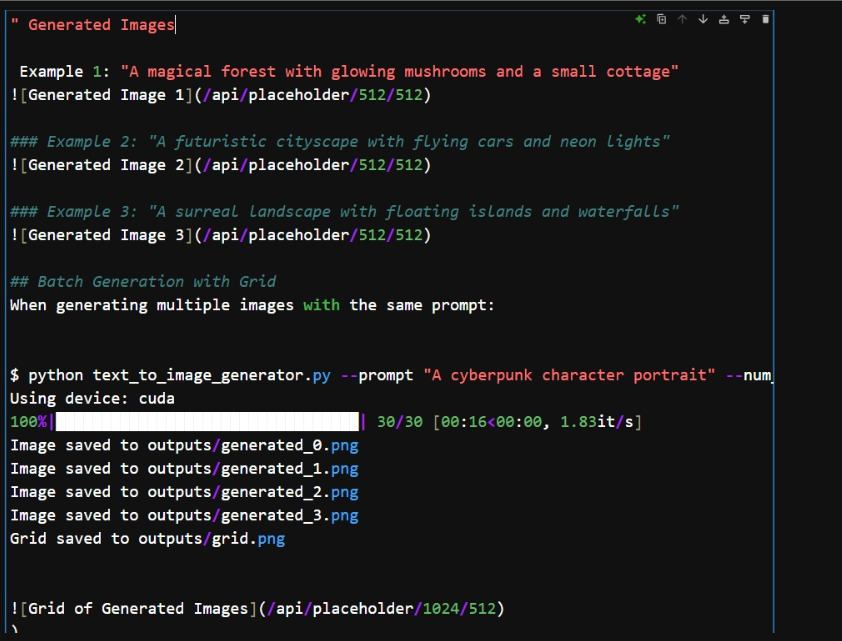